In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(color_codes=True)

# Load and inspect data

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

In [3]:
wine.shape

(129971, 13)

In [4]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [6]:
wine.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


# Data Wrangling

The variety column is going to be used as our label column further down. Let's take care of this now and make sure the quantity of labels matches the quantity of data entries in the description field.

In [7]:
# Drop missing label row from DataFrame
wine = wine[pd.notnull(wine['variety'])]

We can see above that we have some missing country data. Given we have a complete winery field, let's fill in the missing country values by mapping in corresponding country information based on where the winery is located

In [8]:
# Fill in missing country values based on winery
winery_to_country = dict()

for i in zip(wine['winery'], wine['country']):
    if i[0] not in winery_to_country and pd.notnull(i[1]):
        winery_to_country[i[0]] = i[1]

wine['country'] = wine['winery'].map(winery_to_country)

# EDA

### How many unique values in this dataset?

In [9]:
column_unique = ['country', 'variety', 'taster_name']

for column in column_unique:
        value = wine[column].nunique()
        print('Unique {}: {}'.format(column, value))

Unique country: 43
Unique variety: 707
Unique taster_name: 19


### Which country produces the most wine?

In [10]:
def plot_quantity(df, column, title, kind='bar'):
    """Create a count plot for any given column."""
    # Adjust figure size
    plt.figure(figsize=(16, 6))
    
    # Plot
    df[column].value_counts().plot(kind=kind)
    
    # Set Labels
    plt.ylabel('Count', size=12)
    plt.title(title, size=16)

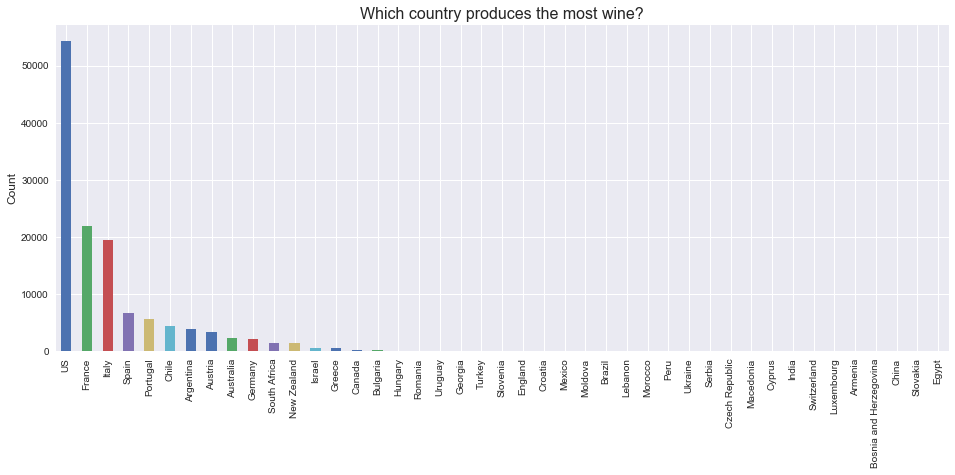

In [11]:
plot_quantity(wine,
              'country', 
              title='Which country produces the most wine?')

### Which varietal is produced the most?

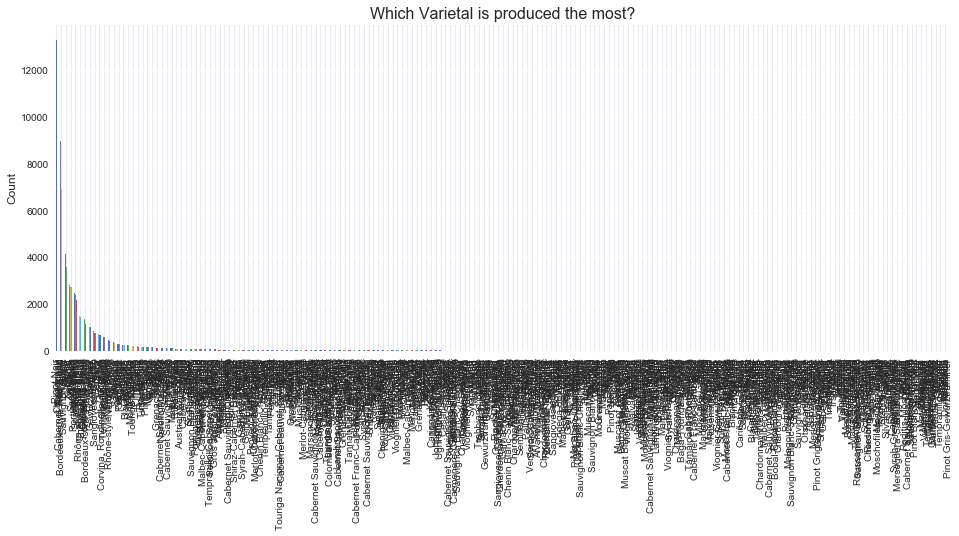

In [12]:
plot_quantity(wine,
              'variety', 
              title='Which Varietal is produced the most?')

The plot above doesn't give us much information given the large number of entries. It is impossible to tell all the varietals and their corresponding quantities.

There are over 707 varietals in this dataset, many of which only make a single entry. This will increase the complexity of the model and slow down processing down. In order to avoid this issues, I'm going to par down the dataset to keep the top ten procuded varietals.

In [13]:
# Set the number of varietals to keep
varietals_to_keep = 10

# Get the top varietals and store it as a list: LABEL
LABEL = wine['variety'].value_counts()\
        .nlargest(varietals_to_keep).index.tolist()

# Filter dataframe to keep the values in LABEL
df = wine[wine['variety'].isin(LABEL)]

df.shape

(71322, 13)

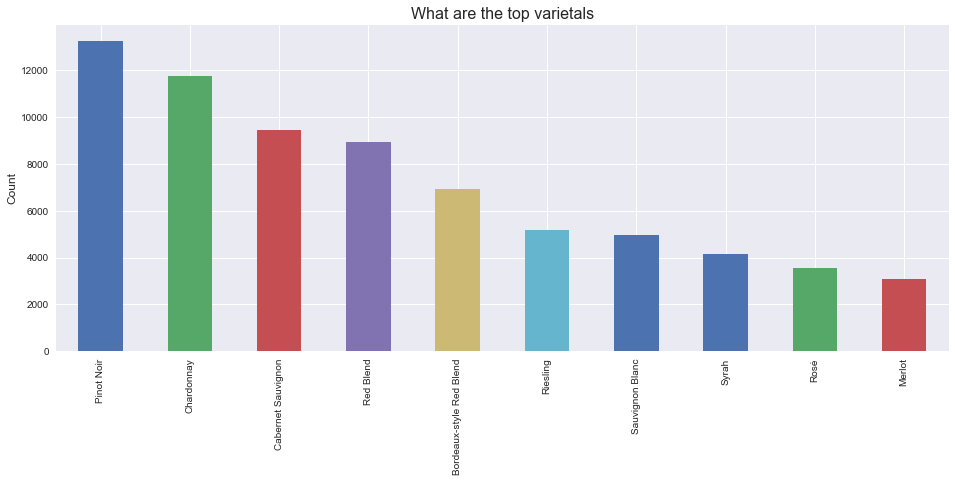

In [14]:
plot_quantity(df,
              'variety',
              title='What are the top varietals')

### What is the relationship between price and points, and their respective distributions.

([<matplotlib.axis.XTick at 0x1a17cd6c50>,
 <a list of 11 Text xticklabel objects>)

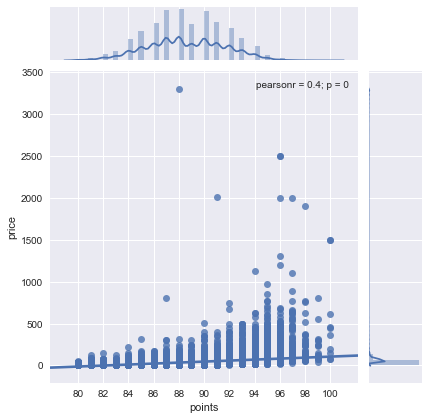

In [15]:
sns.jointplot(x='points', y='price', data=df, 
              kind='reg', 
              dropna=True)
plt.xticks(np.arange(min(df['points']), 
                     max(df['points']) +1, 2))

### What is the relationship between price and points per varietal?

Text(0.5,1,'Best quality wine for the cost (on average)')

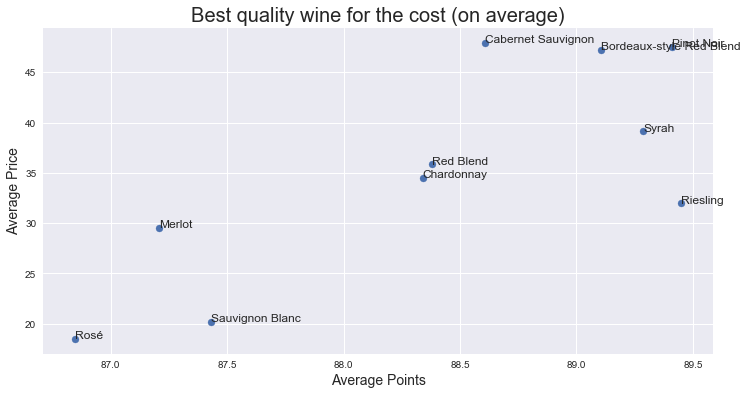

In [16]:
# Prep data to plot: agg
agg = df.groupby('variety', as_index=False).agg({'points': 'mean',
                                                 'price': 'mean',
                                                 'country': 'count'})

# Adjust plot size
plt.figure(figsize=(12, 6))
# plot
plt.scatter(agg['points'], agg['price'])

# Label Data Points
for i, text in enumerate(agg['variety']):
    plt.annotate(text, (agg['points'][i], agg['price'][i]))
    
# Label Plot
plt.xlabel('Average Points', size=14)
plt.ylabel('Average Price', size=14)
plt.title('Best quality wine for the cost (on average)', size=20)
    

# Statistics

From the graph above, we can see that the United States produces the most amount of wine compared to any other nation, with the European quartet of  France, Italy, Spain, and Portugal as the next four.

Even though the United States produces by far the most amount of wine, I'm interested in finding out if this hurts the quality of wine that is being put out, and the Europeans, although making fewer quantity, actually make higher based on this point system.

Let's find out.

### Is there a significant different in quality of wines betwen American wines and European wines?

$H_{O}$: There is no difference between the quality of wines from the U.S vs. wines from Europe.

$H_{A}$: There is a significant difference in quality between wines from the U.S. vs. wines from Europe.

#### Add a continent column to the dataframe.

In [17]:
europe = ['France', 'Italy', 'Spain', 'Portugal']
us = ['US']

country_to_continent = {}

for i in df['country']:
    if i in europe:
        country_to_continent[i] = 'Europe'
    elif i in us:
        country_to_continent[i] = 'USA'
    else:
        country_to_continent[i] = 'other'

df['continent'] = df['country'].map(country_to_continent)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Wine Quality - Europe vs. US')

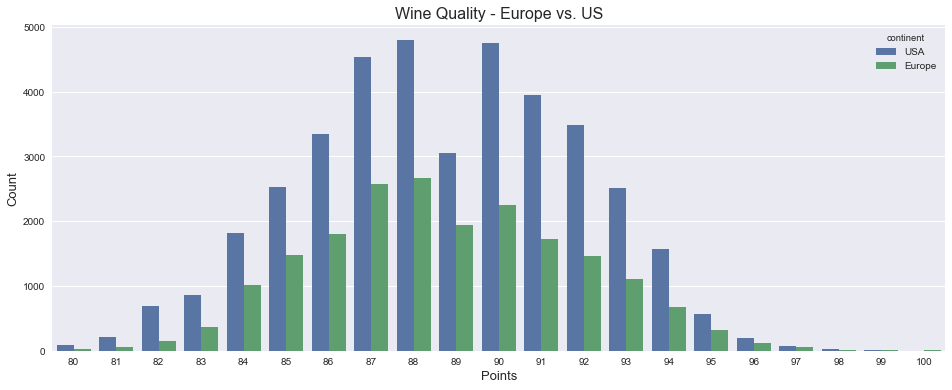

In [18]:
# Set figure size
plt.figure(figsize=(16, 6))

# Set Plot
sns.countplot(x = 'points', hue='continent', 
              data=df[df['continent'] != 'other'])

# Set Labels
plt.xlabel('Points', size=13)
plt.ylabel('Count', size=13)
plt.title('Wine Quality - Europe vs. US', size=16)

The graph above suggest American wines are may be higher quality, however, this may be simply because there's a higher quantity of American wines in the dataset. Let's calculate the t-score and p-value to be sure.

In [19]:
# Split points for europe and us: us_points, eu_points
us_points = df[df['continent'] =='USA']['points']
eu_points = df[df['continent'] =='Europe']['points']

# Calculate mean points for american and europe: us_mean, eu_mean
us_mean, eu_mean = np.mean(us_points), np.mean(eu_points) 

# difference of means
difference_of_means = us_mean - eu_mean

# t-score and p-value
t, p = stats.ttest_ind(us_points, eu_points)

# Standard Error: SE
SE = np.sqrt(np.std(us_points)**2 / len(us_points) + 
             np.std(eu_points)**2 / len(eu_points))

# Margin of Error: merror
merror = 1.96 * SE

# 95% Confidence Interval: conf_int_95
conf_int_95 = [difference_of_means - merror, 
               difference_of_means + merror]

# Print results
msg = 'The average points for {} is: {:.4}'
print(msg.format('USA', us_mean))
print(msg.format('Europe', eu_mean))
print()

msg_1 = 'The {} is: {:2.3}'
print(msg_1.format('t_score', t))
print(msg_1.format('P-value', p))
print()

print('95% Confidence Interval: {}'.format(conf_int_95))

The average points for USA is: 88.77
The average points for Europe is: 88.66

The t_score is: 4.11
The P-value is: 3.95e-05

95% Confidence Interval: [0.059387619618072186, 0.16506182533361566]


Given the low P-value, below 0.05, we can reject the null hypothesis that the US and European wines have the same quality on average. American wines have higher quality wines, on average, when compared to European wines.

# Machine Learning

In this section, I'm going to build a classification model to predict the wine varietal based on the wine's description.

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# Models to try
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Build model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, Imputer, MaxAbsScaler

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report

### Establish baseline

In [21]:
variety_count = df['variety'].value_counts()
baseline = variety_count[0] / np.sum(variety_count)

print('Pinot Noir is {:2.2%} of the dataset'.format(baseline))

Pinot Noir is 18.61% of the dataset


### Build Basic Model

Let's build a basic model and compare the different model performances. I'm trying to get a sense for how well we can do with an "out of the box" model.

In [22]:
X = df['description']
y = df['variety']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=12)

In [23]:
# Models to try
models = [RandomForestClassifier, 
          LinearSVC, 
          LogisticRegression]

# Vectorizers to try
vects = [CountVectorizer,
         TfidfVectorizer,
         HashingVectorizer]

for model in models:
    for vectorizer in vects:
        pipeline = Pipeline([
            ('vec', vectorizer()),
            ('clf', model())
        ])
        # Fit model
        pipeline.fit(X_train, y_train)
    
        # Measure model accuracy
        print('Model: {}, Vectorizer: {}, Accuracy: {:2.2%}'.format(model.__name__, 
                                                               vectorizer.__name__,
                                                               pipeline.score(X_test, y_test)))

Model: RandomForestClassifier, Vectorizer: CountVectorizer, Accuracy: 68.79%
Model: RandomForestClassifier, Vectorizer: TfidfVectorizer, Accuracy: 68.52%
Model: RandomForestClassifier, Vectorizer: HashingVectorizer, Accuracy: 60.33%
Model: LinearSVC, Vectorizer: CountVectorizer, Accuracy: 77.62%
Model: LinearSVC, Vectorizer: TfidfVectorizer, Accuracy: 80.57%
Model: LinearSVC, Vectorizer: HashingVectorizer, Accuracy: 80.48%
Model: LogisticRegression, Vectorizer: CountVectorizer, Accuracy: 80.45%
Model: LogisticRegression, Vectorizer: TfidfVectorizer, Accuracy: 79.98%
Model: LogisticRegression, Vectorizer: HashingVectorizer, Accuracy: 78.02%


-------
Based on the different combinations of models above, we can see we the best model combination includes LinearSVC with TfidfVectorizer. This combination built us an "out of the box" model that is **80.57%** accurate.

Below, I'll add a couple of preprocessing steps, as well add more features to see if I can improve upon the models performance

## Preprocessing tools

We need tools to preprocess our text and numeric data. We'll create those tools here. The combine_text_columns function will take a DataFrame of text columns and return a single series where all of the text in the columns has been joined together.

We'll then create FunctionTransformer objects that select our text and numeric data from the dataframe.

In [24]:
NUMERIC_COLUMNS = ['price', 'points']
TO_DROP = ['variety', 'continent', 'title', 'taster_twitter_handle']

def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + TO_DROP):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.
        
        :param data_frame: The data as read in with read_csv (no preprocessing necessary)
        :param to_drop (optional): Removes the numeric and label columns by default.
    """
    # drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # joins all of the text items in a row (axis=1)
    # with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [25]:
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

In [26]:
get_text_data.fit_transform(df.head(5))

3     US Pineapple rind, lemon pith and orange bloss...
4     US Much like the regular bottling from 2012, t...
10    US Soft, supple plum envelopes an oaky structu...
12    US Slightly reduced, this wine offers a chalky...
14    US Building on 150 years and six generations o...
dtype: object

In [27]:
get_numeric_data.fit_transform(df.head())

,price,points
3,13.0,87
4,65.0,87
10,19.0,87
12,34.0,87
14,12.0,87


## Train model pipeline

Here I'll train the final pipeline that takes text and numeric data, preprocesses the data, and train the model

In [28]:
X = df.drop(TO_DROP, axis=1)
y = df['variety']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=12)

In [29]:
# Create pipeline
pl = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('imputer', Imputer())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', TfidfVectorizer(ngram_range=(1, 3),
                                               lowercase=True,
                                               stop_words='english'))
            ]))
        ])),
    ('scale', MaxAbsScaler()),
    ('clf', LinearSVC())
])

# fit the pipeline to the training data
pl.fit(X_train, y_train)

# print the score of the trained pipeline
print('Accuracy: {:2.2%}'.format(pl.score(X_test, y_test)))

Accuracy: 88.72%


### Predict test set

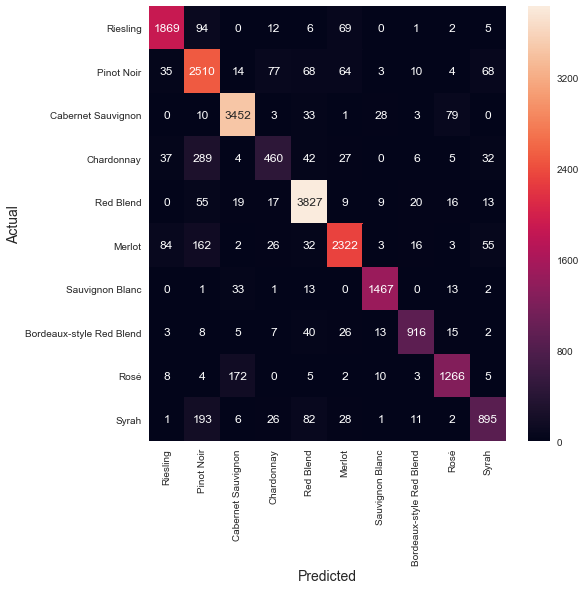

In [30]:
# Predict on test set
y_pred = pl.predict(X_test)

# Draw confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

labels = df['variety'].unique()

plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat,
            annot = True,
            fmt = 'd',
            xticklabels=labels,
            yticklabels=labels)

# Set Labels
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [31]:
print(classification_report(y_test, y_pred,
                                    target_names = labels))

                          precision    recall  f1-score   support

                Riesling       0.92      0.91      0.91      2058
              Pinot Noir       0.75      0.88      0.81      2853
      Cabernet Sauvignon       0.93      0.96      0.94      3609
              Chardonnay       0.73      0.51      0.60       902
               Red Blend       0.92      0.96      0.94      3985
                  Merlot       0.91      0.86      0.88      2705
         Sauvignon Blanc       0.96      0.96      0.96      1530
Bordeaux-style Red Blend       0.93      0.89      0.91      1035
                    Rosé       0.90      0.86      0.88      1475
                   Syrah       0.83      0.72      0.77      1245

             avg / total       0.89      0.89      0.89     21397

